# Spam Message Classification

## Get the Data

We'll be using a SMS Spam Collection dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)! The file we are using contains a collection of more than five thousand SMS phone messages. 

In [88]:
import nltk

In [89]:
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


Let's import all the libraries we think we will use:

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We'll use **read_csv** and make note of the **sep** argument, we can also specify the desired column names by passing in a list of *names*.

In [91]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['label', 'message'])

In [92]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [93]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [94]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's add a new column to detect how long the text messages are:

In [95]:
messages['length'] = messages['message'].apply(len)

In [96]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization

<AxesSubplot:xlabel='length', ylabel='Count'>

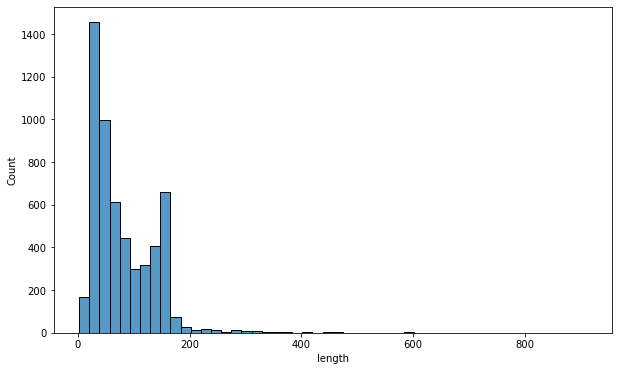

In [97]:
plt.figure(figsize=(10,6))
sns.histplot(messages['length'], bins=50)

Looks like text length may be a good feature to think about! Let's increase the bin size and check.

<AxesSubplot:xlabel='length', ylabel='Count'>

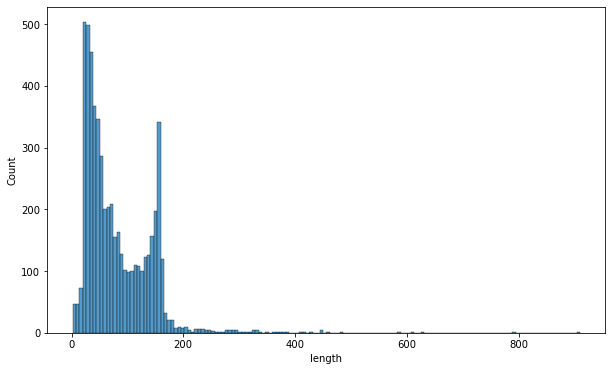

In [98]:
plt.figure(figsize=(10,6))
sns.histplot(messages['length'], bins=150)

If we increase the bin size to 150, we notice that there are two peaks in the plot.

Let's focus on the idea of trying to see if message length is a distinguishing feature between ham and spam:

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

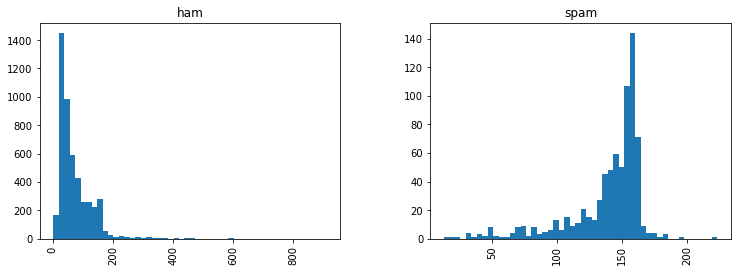

In [99]:
messages.hist(column='length', by='label', bins=50, figsize=(12,4))

Very interesting! We know the horizontal-axis represents the length of the messages and the vertical-axis represents the frequency of the messages or the count. Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

In [100]:
import string

In [101]:
from nltk.corpus import stopwords

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

In [104]:
def custom_analyzer(message):
    """
    This removes all punctuation and all stopwords and returns a list of the cleaned text. 
    """
    
    message = message.translate(str.maketrans('', '', string.punctuation))
    
    # Now just remove any stopwords
    return [word for word in message.split() if word.lower() not in stopwords.words('english')]

In [105]:
# Check to make sure its working
messages['message'].head(5).apply(custom_analyzer)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [106]:
bow_transformer = CountVectorizer(analyzer=custom_analyzer).fit(messages['message'])

Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [107]:
messages_bow_matrix = bow_transformer.transform(messages['message'])

In [109]:
print('Shape of sparse matrix: ', messages_bow_matrix.shape) #5572 messages(rows) and 11425 bag of words(columns)
print('Number of non zero occurences: ', messages_bow_matrix.nnz)

Shape of sparse matrix:  (5572, 11425)
Number of non zero occurences:  50548


In [110]:
print(len(bow_transformer.vocabulary_))

11425


In [111]:
print(len(messages['message']))

5572


## TF-IDF

After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

In [112]:
from sklearn.feature_extraction.text import TfidfTransformer

In [113]:
tfidf_transformer = TfidfTransformer().fit(messages_bow_matrix) 
#Here messages_bow is a sparse matrix created above using bow_transformer

To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [114]:
messages_tfidf = tfidf_transformer.transform(messages_bow_matrix)
print(messages_tfidf.shape)

(5572, 11425)


In [119]:
message4 = messages['message'][3]
bow4 = bow_transformer.transform([message4])
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


## Training a Model

With messages represented as vectors, we can finally train our spam/ham classifier. We can use the Naive Bayes classifier algorithm for this.

In [120]:
from sklearn.naive_bayes import MultinomialNB

In [121]:
spam_detection_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message and checking how we do:

In [122]:
print('Predicted for 4th message: ', spam_detection_model.predict(tfidf4)[0])
print('Expected for 4th message: ', messages['label'][3])

Predicted for 4th message:  ham
Expected for 4th message:  ham
